## Final: Spacy

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import spacy
import re

import xgboost as xgb

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer


In [4]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

### Data

In [5]:
df = pd.read_csv('CLEANDATA/Clean_MT.csv', index_col=False)
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        3898 non-null   object
 1   medical_specialty  3898 non-null   object
 2   sample_name        3898 non-null   object
 3   transcription      3898 non-null   object
 4   keywords           3898 non-null   object
dtypes: object(5)
memory usage: 152.4+ KB


In [7]:
df['medical_specialty'].value_counts()

medical_specialty
 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
 ENT - Otolaryngology               84
 Neurosurgery                       81
 Ophthalmology                      79
 Discharge Summary                  77
 Nephrology                         63
 Hematology - Oncology              62
 Pain Management                    58
 Office Notes                       44
 Pediatrics - Neonatal              42
 Podiatry                           42
 Emergency Room Reports             31
 Dermatology                        25
 Dentistry                          25
 Cosmetic / Plastic Surgery         25
 Letter

#### Filtering

In [8]:
# get rows with medical_specialty with more than 100 samples
df = df.groupby('medical_specialty').filter(lambda x: len(x) > 100)

In [9]:
df['medical_specialty'].value_counts()

medical_specialty
 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3010 entries, 3 to 3887
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        3010 non-null   object
 1   medical_specialty  3010 non-null   object
 2   sample_name        3010 non-null   object
 3   transcription      3010 non-null   object
 4   keywords           3010 non-null   object
dtypes: object(5)
memory usage: 141.1+ KB


In [11]:
# remove general category
df = df[~df['medical_specialty'].str.contains('Surgery|Consult - History and Phy.|General Medicine|SOAP / Chart / Progress Notes|Radiology')]

In [12]:
df['medical_specialty'].value_counts()

medical_specialty
 Orthopedic                    303
 Cardiovascular / Pulmonary    280
 Gastroenterology              195
 Neurology                     168
 Urology                       140
 Obstetrics / Gynecology       130
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1216 entries, 3 to 3887
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1216 non-null   object
 1   medical_specialty  1216 non-null   object
 2   sample_name        1216 non-null   object
 3   transcription      1216 non-null   object
 4   keywords           1216 non-null   object
dtypes: object(5)
memory usage: 57.0+ KB


### Pre-Process

In [14]:
def Process_Doc(doc):
    # Check if the input is a list, if so, join it into a single string
    if isinstance(doc, list):
        doc = ' '.join(doc)
    # lowercase
    doc = doc.lower()
    # Remove special characters and numbers using regex
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    # Remove extra whitespace
    doc = re.sub(r'\s+', ' ', doc).strip()
    # tokenize
    doc = nlp(doc)
    # remove stopwords
    doc = [token.text for token in doc if not token.is_stop and token.is_alpha]
    doc = ' '.join(doc)
    # Lemmatize
    doc = [lemmatizer.lemmatize(word) for word in doc.split()]
    return ' '.join(doc)

In [70]:
sample = df['transcription'].iloc[6]
sample

'PROCEDURE: , Elective male sterilization via bilateral vasectomy.,PREOPERATIVE DIAGNOSIS:  ,Fertile male with completed family.,POSTOPERATIVE DIAGNOSIS:,  Fertile male with completed family.,MEDICATIONS:  ,Anesthesia is local with conscious sedation.,COMPLICATIONS: , None.,BLOOD LOSS: , Minimal.,INDICATIONS:  ,This 34-year-old gentleman has come to the office requesting sterilization via bilateral vasectomy.  I discussed the indications and the need for procedure with the patient in detail, and he has given consent to proceed.  He has been given prophylactic antibiotics.,PROCEDURE NOTE: , Once satisfactory sedation have been obtained, the patient was placed in the supine position on the operating table.  Genitalia was shaved and then prepped with Betadine scrub and paint solution and were draped sterilely.  The procedure itself was started by grasping the right vas deferens in the scrotum, and bringing it up to the level of the skin.  The skin was infiltrated with 2% Xylocaine and pun

'2-D ECHOCARDIOGRAM,Multiple views of the heart and great vessels reveal normal intracardiac and great vessel relationships.  Cardiac function is normal.  There is no significant chamber enlargement or hypertrophy.  There is no pericardial effusion or vegetations seen.  Doppler interrogation, including color flow imaging, reveals systemic venous return to the right atrium with normal tricuspid inflow.  Pulmonary outflow is normal at the valve.  Pulmonary venous return is to the left atrium.  The interatrial septum is intact.  Mitral inflow and ascending aorta flow are normal.  The aortic valve is trileaflet.  The coronary arteries appear to be normal in their origins.  The aortic arch is left-sided and patent with normal descending aorta pulsatility.'

'PROCEDURE: , Elective male sterilization via bilateral vasectomy.,PREOPERATIVE DIAGNOSIS:  ,Fertile male with completed family.,POSTOPERATIVE DIAGNOSIS:,  Fertile male with completed family.,MEDICATIONS:  ,Anesthesia is local with conscious sedation.,COMPLICATIONS: , None.,BLOOD LOSS: , Minimal.,INDICATIONS:  ,This 34-year-old gentleman has come to the office requesting sterilization via bilateral vasectomy.  I discussed the indications and the need for procedure with the patient in detail, and he has given consent to proceed.  He has been given prophylactic antibiotics.,PROCEDURE NOTE: , Once satisfactory sedation have been obtained, the patient was placed in the supine position on the operating table.  Genitalia was shaved and then prepped with Betadine scrub and paint solution and were draped sterilely.  The procedure itself was started by grasping the right vas deferens in the scrotum, and bringing it up to the level of the skin.  The skin was infiltrated with 2% Xylocaine and punctured with a sharp hemostat to identify the vas beneath.  The vas was brought out of the incision carefully.  A 2-inch segment was isolated, and 1-inch segment was removed.  The free ends were cauterized and were tied with 2-0 silk sutures in such a fashion that the ends double back on themselves.  After securing hemostasis with a cautery, the ends were allowed to drop back into the incision, which was also cauterized.,Attention was now turned to the left side.  The vas was grasped and brought up to the level of the skin.  The skin was infiltrated with 2% Xylocaine and punctured with a sharp hemostat to identify the vas beneath.  The vas was brought out of the incision carefully.  A 2-inch segment was isolated, and 1-inch segment was removed.  The free ends were cauterized and tied with 2-0 silk sutures in such a fashion that the ends double back on themselves.  After securing hemostasis with the cautery, the ends were allowed to drop back into the incision, which was also cauterized.,Bacitracin ointment was applied as well as dry sterile dressing.  The patient was awakened and was returned to Recovery in satisfactory condition.'

In [16]:
Process_Doc(sample)

'd echocardiogrammultiple view heart great vessel reveal normal intracardiac great vessel relationship cardiac function normal significant chamber enlargement hypertrophy pericardial effusion vegetation seen doppler interrogation including color flow imaging reveals systemic venous return right atrium normal tricuspid inflow pulmonary outflow normal valve pulmonary venous return left atrium interatrial septum intact mitral inflow ascending aorta flow normal aortic valve trileaflet coronary artery appear normal origin aortic arch leftsided patent normal descending aorta pulsatility'

### Classification

In [17]:
#preprocess all the transcriptions
df['pr_transcription'] = df['transcription'].apply(Process_Doc)

#### Train Test Split

In [18]:
X = df['pr_transcription']
y = df['medical_specialty']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 972
Testing set size: 244


--------------------

In [20]:
# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

------------------

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [22]:
# make predictions
y_pred = pipeline.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8073770491803278


In [23]:
# classification report
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.74      1.00      0.85        49
           Gastroenterology       0.97      0.86      0.91        37
                  Neurology       0.83      0.45      0.59        33
    Obstetrics / Gynecology       1.00      0.61      0.76        28
                 Orthopedic       0.72      0.96      0.82        70
                    Urology       1.00      0.63      0.77        27

                   accuracy                           0.81       244
                  macro avg       0.88      0.75      0.78       244
               weighted avg       0.84      0.81      0.80       244



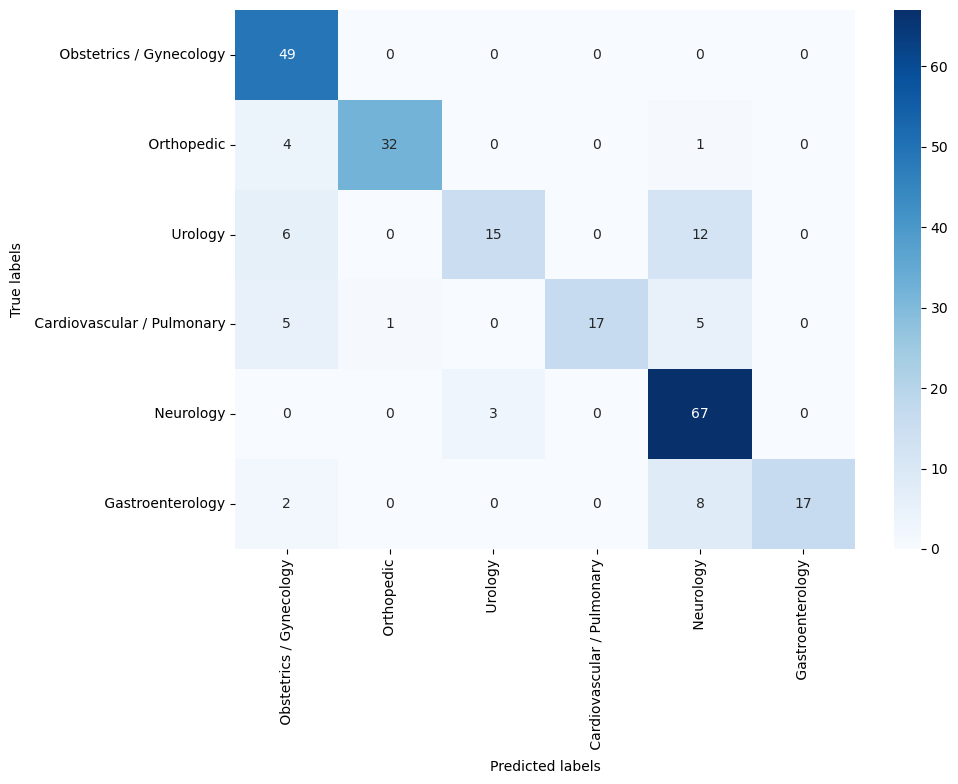

In [24]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


------------

In [25]:
# Grid search

param_grid = { 
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.1, 1],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 1000, 2000],
    'nb__alpha': (1e-2, 1e-3)
}

In [26]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

In [27]:
# Train the model using GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': (0.01, 0.001),
                         'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
                         'tfidf__max_features': [500, 1000, 2000],
                         'tfidf__min_df': [0.01, 0.1, 1],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [28]:
# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Make predictions on the test set with the best model
y_pred = grid_search.predict(X_test)

Best Hyperparameters: {'nb__alpha': 0.001, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


In [29]:
# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.88      0.92      0.90        49
           Gastroenterology       0.97      0.84      0.90        37
                  Neurology       0.57      0.76      0.65        33
    Obstetrics / Gynecology       1.00      0.89      0.94        28
                 Orthopedic       0.91      0.83      0.87        70
                    Urology       0.93      0.96      0.95        27

                   accuracy                           0.86       244
                  macro avg       0.88      0.87      0.87       244
               weighted avg       0.88      0.86      0.87       244



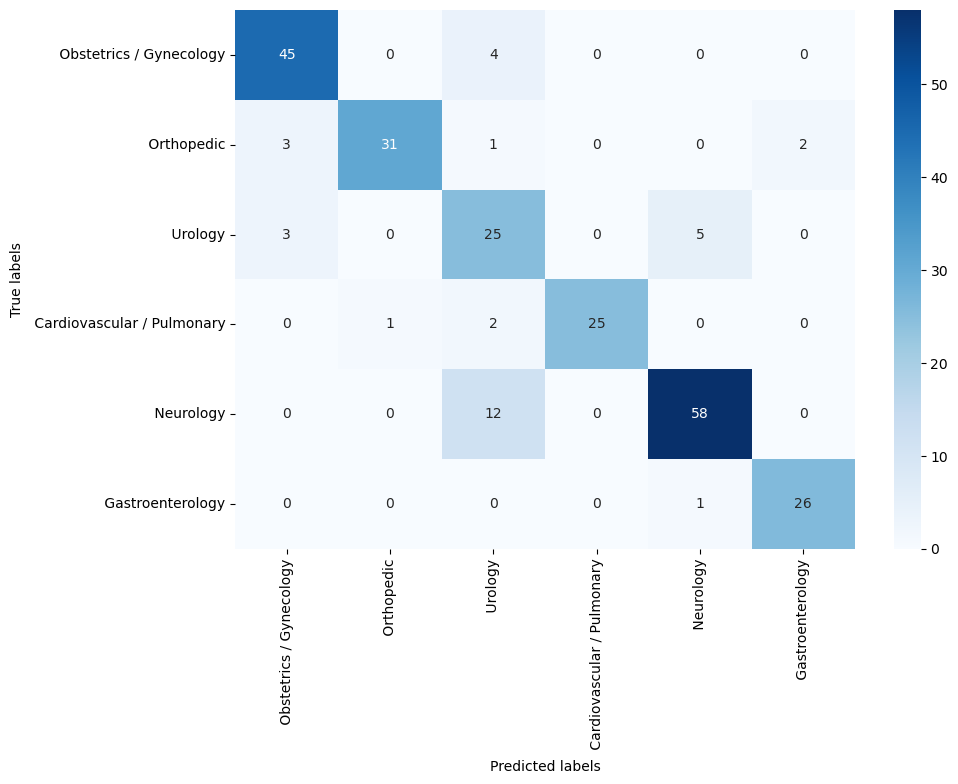

In [30]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


------------------

In [31]:
pipeline_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [32]:
pipeline_2.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('knn', KNeighborsClassifier())])

In [33]:
# make predictions
y_pred = pipeline_2.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8811475409836066


---------------

In [34]:
pipeline_3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rand', RandomForestClassifier())
])

In [35]:
pipeline_3.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('rand', RandomForestClassifier())])

In [36]:
# make predictions
y_pred = pipeline_3.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8319672131147541


------------------

In [37]:
pipeline_4 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('comp', ComplementNB())
])

In [38]:
pipeline_4.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('comp', ComplementNB())])

In [39]:
# make predictions
y_pred = pipeline_4.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9262295081967213


-------------

In [63]:
# hyperparameter tuning for ComplementNB

param_grid = {
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.1, 1],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 1000, 2000],
    'comp__alpha': (0.01, 0.1, 1, 10)
}

In [64]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipeline_4, param_grid, cv=5, n_jobs=-1, verbose=1)

In [65]:
# Train the model using GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'comp__alpha': 0.01, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


In [66]:
# Make predictions on the test set with the best model
y_pred = grid_search.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.90      0.96      0.93        49
           Gastroenterology       1.00      0.92      0.96        37
                  Neurology       0.76      0.79      0.78        33
    Obstetrics / Gynecology       1.00      0.96      0.98        28
                 Orthopedic       0.93      0.93      0.93        70
                    Urology       0.96      0.96      0.96        27

                   accuracy                           0.92       244
                  macro avg       0.93      0.92      0.92       244
               weighted avg       0.92      0.92      0.92       244



In [67]:
# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9221311475409836


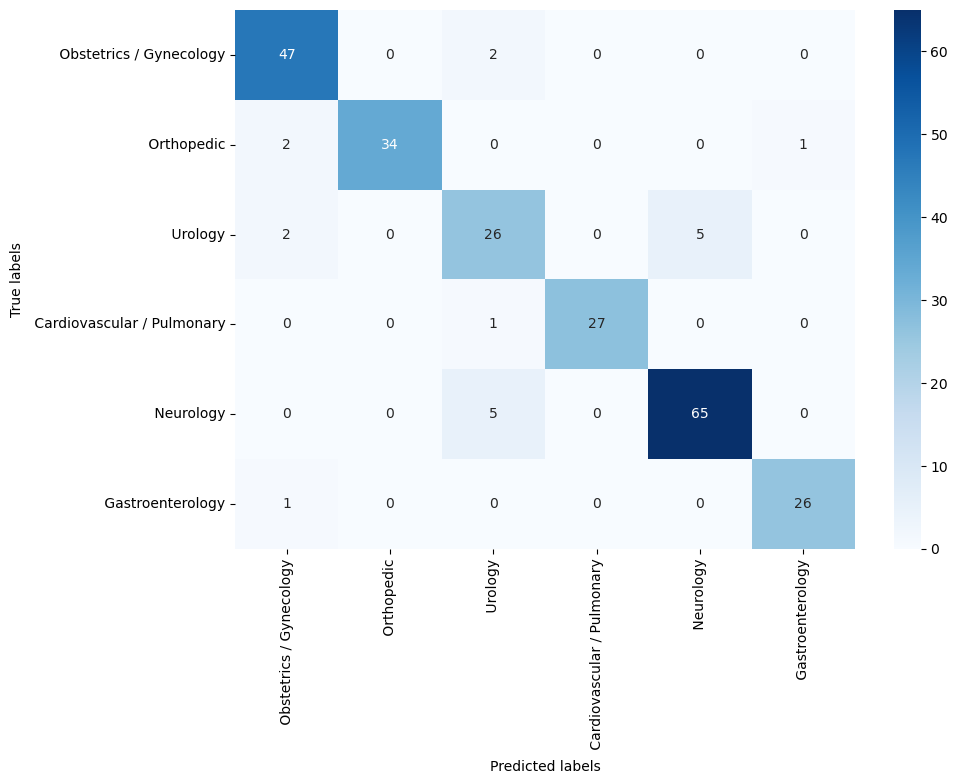

In [68]:

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

-----------------

In [40]:
pipeline_5 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

In [41]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

pipeline_5.fit(X_train, y_train_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [42]:
# make predictions
y_pred = pipeline_5.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred)}")

Accuracy: 0.8278688524590164


----------------------

In [43]:
# find importance of each token per class

# Get the feature names
feature_names = pipeline_5.named_steps['tfidf'].get_feature_names_out()

# Get the feature importances
feature_importances = pipeline_5.named_steps['xgb'].feature_importances_

# Create a DataFrame with the feature names and feature importances
df_feature_importances = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=['feature', 'importance'])

# Get the top 20 most important features
df_feature_importances = df_feature_importances.sort_values('importance', ascending=False).head(20)


/var/folders/0_/jyfznr0x5q53rj2pvwf26qbw0000gn/T/ipykernel_7689/839499322.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_feature_importances, palette='viridis')


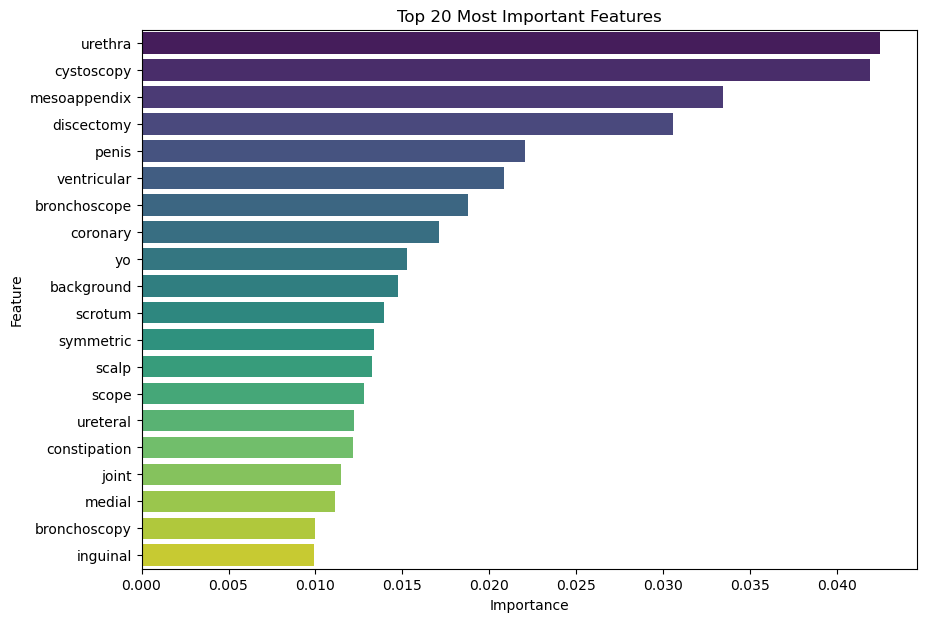

In [44]:

# Plot the top 20 most important features
plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=df_feature_importances, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.show()

----------------

In [45]:
# find importance of each token per medical specialty

# Get the feature importances
feature_importances = pipeline_5.named_steps['xgb'].feature_importances_

# Create a DataFrame with the feature names and feature importances
df_feature_importances = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=['feature', 'importance'])

# Get the top 20 most important features per class

# Create an empty list to store the top 20 most important features per class
top_features_list = []

# Loop through each class
for i, specialty in enumerate(le.classes_):
    # Get the feature importances for the current class
    feature_importances = pipeline_5.named_steps['xgb'].feature_importances_[i * len(feature_names):(i + 1) * len(feature_names)]
    
    # Create a DataFrame with the feature names and feature importances
    df_feature_importances = pd.DataFrame(list(zip(feature_names, feature_importances)), columns=['feature', 'importance'])
    
    # Get the top 20 most important features
    df_top_features = df_feature_importances.sort_values('importance', ascending=False).head(20)
    
    # Add a column with the medical specialty
    df_top_features['medical_specialty'] = specialty
    
    # Append the top features to the list
    top_features_list.append(df_top_features)

# Concatenate all the top features into a single DataFrame
df_top_features_per_class = pd.concat(top_features_list, ignore_index=True)
  

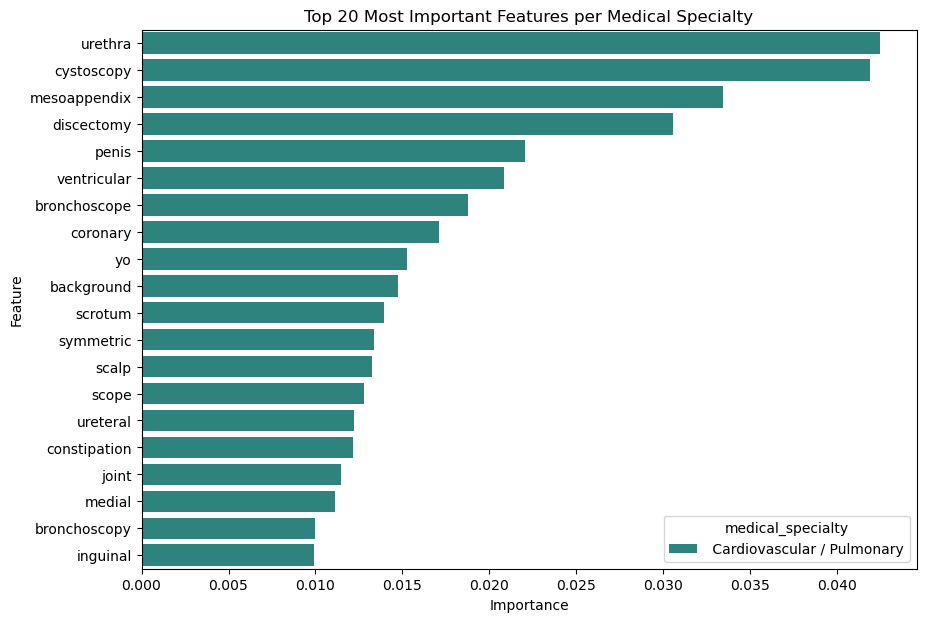

In [46]:
  
# Plot the top 20 most important features per class
plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=df_top_features_per_class, hue='medical_specialty', palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features per Medical Specialty')

plt.show()


----------------

In [47]:
from sklearn.decomposition import NMF

In [48]:
vectorizer = TfidfVectorizer()

In [49]:
topic_model = NMF(n_components = 5)

In [50]:
# Fit the NMF model
W = topic_model.fit_transform(vectorizer.fit_transform(df['pr_transcription']))

# to get W 
H = topic_model.components_ # word component weights for each topic

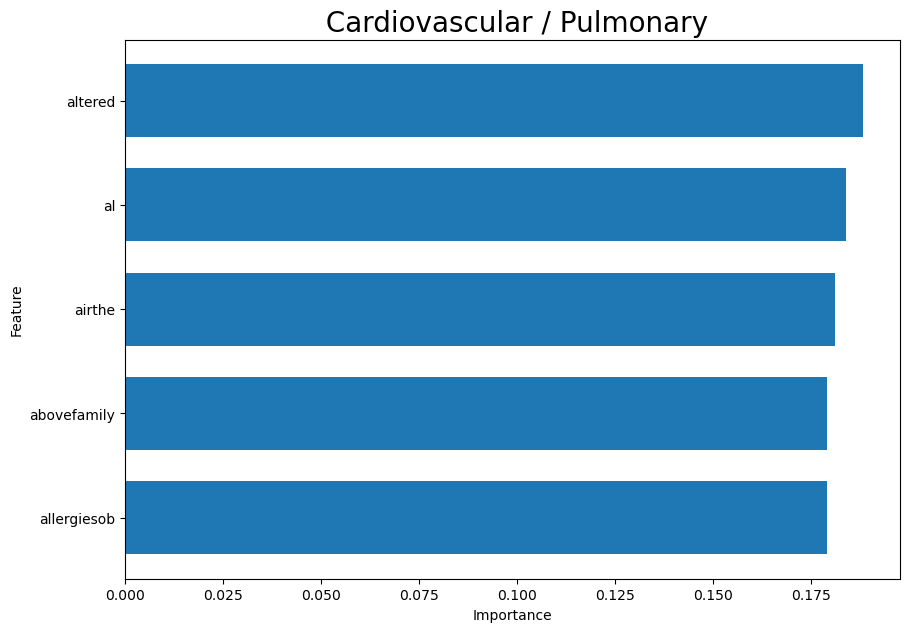

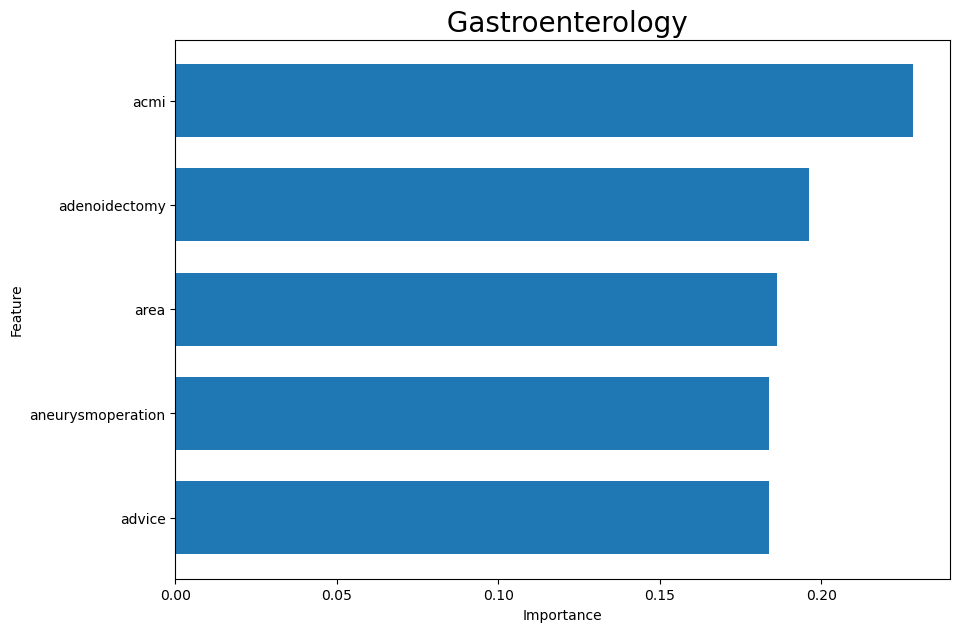

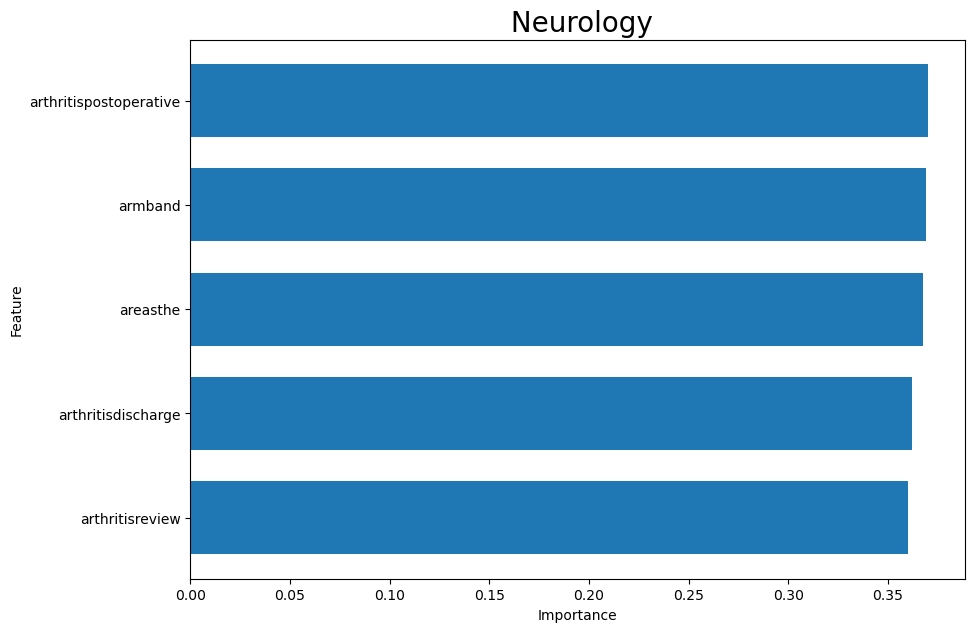

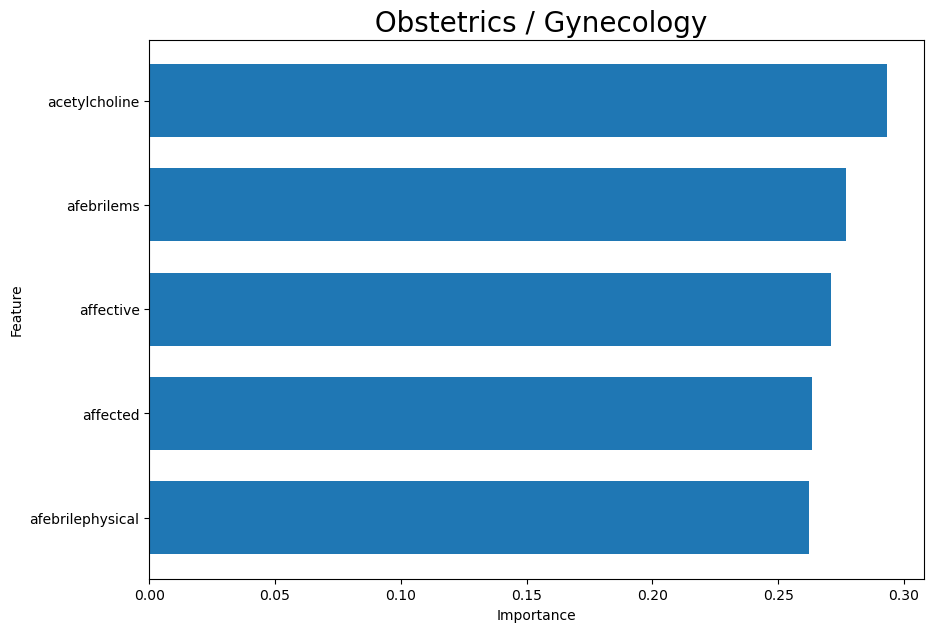

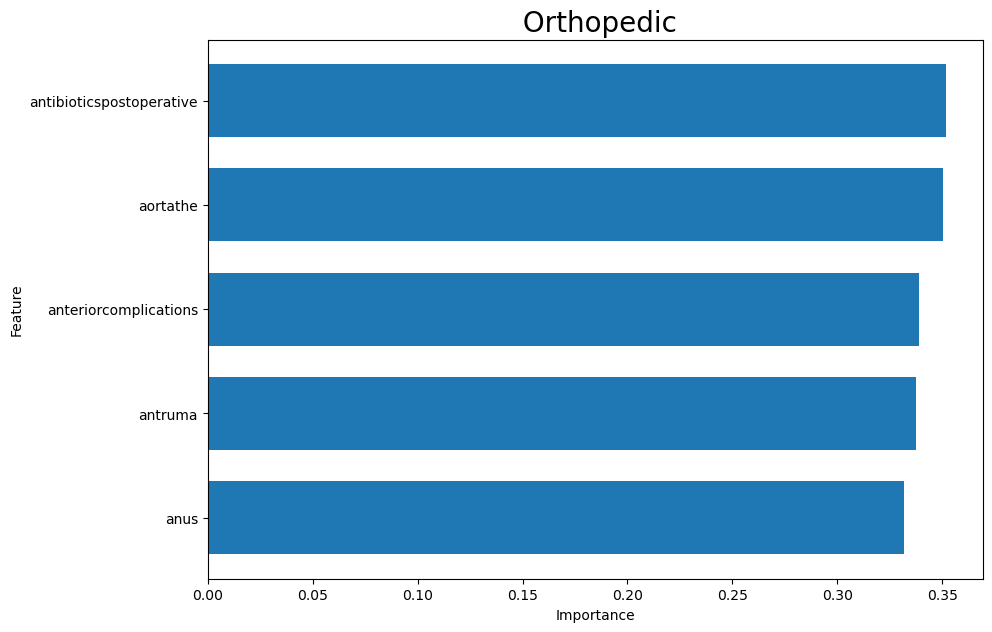

In [69]:
def plot_top_words_separate(W, feature_names, n_top_words, title, classes):
    num_topics = W.shape[1]
    for topic_idx, topic in enumerate(W.T):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        plt.figure(figsize=(10, 7))
        plt.barh(top_features, weights, height=0.7)
        plt.title(f"{classes[topic_idx]}", fontdict={"fontsize": 20})
        plt.gca().invert_yaxis()
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

n_top_words = 5
tfidf_feature_names = vectorizer.get_feature_names_out()
plot_top_words_separate(W, tfidf_feature_names, n_top_words, "Topics in NMF model", le.classes_)
